## Importing libraries

In [28]:
import random
import time
from math import exp, log
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_float_dtype, is_int64_dtype

## Defining the utility functions

In [2]:
def total_bin_weight(data, bins, bin_no):
    """
    Calculate the total weight of items in a specified bin.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the item no. and weights.
    - bins (dict): A dictionary representing a configuration, where keys are bin no. and values are lists of items in each bin.
    - bin_no (int): The index of the bin for which the total weight needs to be calculated.

    Returns:
    float: The total weight of items in the specified bin, rounded to one decimal place.
    """
    return round(sum(data[data.loc[:, 'item_no'] == item].values[0][1] for item in bins[bin_no]), 1)

In [3]:
def calculate_wasted_space(data, bins, bin_size):
    """
    Calculate the total wasted space across all bins.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing item weights and details.
    - bins (dict): A dictionary representing a configuration, where keys are bin no. and values are lists of items in each bin.
    - bin_size (int): The maximum capacity of each bin.

    Returns:
    float: The total wasted space across all bins, rounded to three decimal places.
    """
    sum_wasted_space = 0

    for _bin in bins:
        bin_total_weight = total_bin_weight(data, bins, _bin)
        wasted_space = round((bin_size - bin_total_weight), 3)
        sum_wasted_space += wasted_space

    return round(sum_wasted_space, 3)

In [4]:
def collect_data(temperature, bins, energy):
    """
    Collect and save data to a CSV file for data visualisation.

    Parameters:
    - temperature (float): The temperature value.
    - bins (int): The number of bins.
    - energy (float): The energy value.

    Returns:
    None
    """
    data = {'Temperature': temperature,
            'Number of bins': bins,
            'Energy': energy}

    df = pd.DataFrame(data)
    df.to_csv('DV.csv')

In [5]:
def generate_initial_random_config(data, bin_size):
    """
    Generate an initial solution using the random fitting approach.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the item no. and weights.
    - bin_size (int): The maximum capacity of each bin.

    Returns:
    dict: A dictionary representing the initial configuration, where keys are bin no. and values are lists of items in each bin.
    """
    bin_no = 1
    init_bins = {bin_no: []}  # Opening the first bin

    # Iterate through all the unique items
    for item in data['item_no'].unique():
        # Retrieving the item no.
        current_item_no = item
        
        # Retrie the item weight
        current_weight = data[data.loc[:, 'item_no'] == item].values[0][1]
        
        total_weight = 0

        # Iterate through existing bins
        for b in init_bins:
            # Randomly select an existing bin
            random_bin = np.random.choice(list(init_bins.keys()))
            
            # Retrieve the items from the randomly selected bin
            _bin = init_bins[random_bin] #
            
            # Calculating the total weight of the randomly selected bin
            random_bin_total_weight = total_bin_weight(data, init_bins, random_bin)
            
            # Add the weight of the current unique item to the weight of the randomly selected bin
            total_weight = round((random_bin_total_weight + current_weight), 1)
            
            # Check if there is available space within the randomly selected bin
            if total_weight <= bin_size:
                
                # Adding the item to the bin
                init_bins[random_bin].append(current_item_no)
                break

            # Opening a new bin if the old bins are full
            if total_weight > bin_size:
                bin_no += 1
                init_bins.update({bin_no: [current_item_no]})
                break
                
    return init_bins

In [6]:
def generate_new_config(data, config, bin_size):
    """
    Generate a new configuration by moving a randomly selected item to another random bin.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the item no. and weights.
    - config (dict): A dictionary representing a new configuration, keys are bin no. and values are lists of items in each bin.
    - bin_size (float): The maximum capacity of each bin.

    Returns:
    dict: A new configuration after moving an item to another random bin.
    """
    bin_found_flag = False
    
    # Select a random bin
    random_bin_0 = np.random.choice(list(config.keys()))
    
    # Select a random item in the randoml
    random_item = np.random.choice(config[random_bin_0])
    
    # Popping the selected item from the bin
    random_item = config[random_bin_0].pop(config[random_bin_0].index(random_item))
    
    # Retriev the weight of the random item
    random_item_weight = data[data.loc[:, 'item_no'] == random_item].values[0][1]
    
    random_bin_1_list = [random_bin_0]
    
    # Generate a random order of bin in which we try to fit the item into
    while len(random_bin_1_list) < len(config):
        random_bin_1 = np.random.choice(list(config.keys()))

        if random_bin_1 in random_bin_1_list:
            continue

        random_bin_1_list.append(random_bin_1)

    random_bin_1_count = 1
    
    # Iterate through the bins in the random order until an available space is found
    while bin_found_flag is False:
        random_bin_1 = random_bin_1_list[random_bin_1_count]
        total_weight = 0
        
        total_weight_random_bin_1 = total_bin_weight(data, config, random_bin_1)
        
        # Check if the sum of the weight of the items in the random bin and the weight of the random item exceed bin size
        if (total_weight_random_bin_1 + random_item_weight) <= bin_size:
            # Fit the random item into the random bin
            config[random_bin_1].append(random_item)

            bin_found_flag = True
            break

        random_bin_1_count += 1
        
        # If the random item cannot fit into any of the existing bin then open a new bin
        if random_bin_1_count == len(random_bin_1_list):
            config.update({int(max(list(config.keys()))) + 1: [random_item]})
            bin_found_flag = True

    # Removing empty bins
    config = {_bin: _item for _bin, _item in config.items() if _item}

    return config

In [24]:
def objective_function(data, config, bin_size):
    """
    Calculate the energy (objective function value) of a given configuration.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the item no. and weights.
    - config (dict): The current configuration represented as a dictionary where keys are bin numbers and values are lists of items in each bin.

    Returns:
    float: The energy value calculated based on the squared total weight of items in each bin.
    """
    score = 0

    for _bin in config:
        score_i = ((total_bin_weight(data, config, _bin)/bin_size) ** 2) / len(config)
        score += score_i

    energy = round(score, 3)
    return energy

## Defining the Simulated Annealing function

In [26]:
def simulated_annealing(data, bin_size, temp, temp_stop, iteration, cooling_rate):
    """
    Perform simulated annealing to find an optimal bin configuration.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the item no. and weights.
    - bin_size (float): The maximum capacity of each bin.
    - temp (float): The initial starting temperature for simulated annealing.
    - temp_stop (float): The stopping temperature for simulated annealing.
    - iteration (int): The number of iterations at each temperature.
    - cooling_rate (float): The cooling rate for the temperature.

    Returns:
    dict: The optimal bin configuration found by simulated annealing.
    """
    temperature = []
    bins = []
    energy = []

    # Shuffling the items in the dataset
    data = data.sample(frac=1)

    start_time = time.time()
    
    # Generate the initial configuration with random fitting
    best_config = generate_initial_random_config(data, bin_size)

    print('Initial no. of bins:', len(best_config), '| Initial score:', objective_function(data, best_config, bin_size))

    while temp > temp_stop:
        current_config = deepcopy(best_config)

        for i in range(iteration):
            
            # Generate a new configuration using the current configuration
            new_config = generate_new_config(data, deepcopy(current_config), bin_size)
            
            # Calculate the energy of the current and new configuration
            energy_current_config = objective_function(data, current_config, bin_size)
            energy_new_config = objective_function(data, new_config, bin_size)
            
            # Calculate the difference in energy between the new and current configuration
            delta_energy = round((energy_new_config - energy_current_config), 3)

            if delta_energy > 0:
                # Accept a good move
                current_config = deepcopy(new_config)
            else:
                random_probability_test = random.uniform(0, 1)
                
                # Calculate Boltzmann distribution
                metropolis = exp(delta_energy / temp)
                
                # Check whether a bad move can be accepted
                if metropolis >= random_probability_test:
                    # Accept a bad move
                    current_config = deepcopy(new_config)

            energy_current_config = objective_function(data, deepcopy(current_config), bin_size)
            
            #Check whether the new configuration is better than the best current known configuration
            if energy_current_config > objective_function(data, deepcopy(best_config), bin_size):
                best_config = deepcopy(current_config)

            temperature.append(round(temp, 3))
            bins.append(len(best_config))
            energy.append(round(objective_function(data, current_config, bin_size), 3))

        print('Temperature:', round(temp, 3), '| Current best no. of bins:', len(best_config))

        temp *= cooling_rate
    
    stop_time = time.time()

    elapsed_time = stop_time - start_time
    elasped_time_mininute = round((elapsed_time/60),2)
    print('---Execution time:', elasped_time_mininute,'minutes---')
    
    collect_data(temperature, bins, energy)

    print('Optimal no. of bins found:', len(best_config))
    return best_config, elasped_time_mininute

## Reading the csv file

### Note
Please upload a file with a <b>.csv</b> file extension. <br>

Ensure the following requirements are met:
- The file is <b>not</b> empty.
- The dtype of the data in the csv file is <b>float</b> type.
- Make sure the csv file <b>does not have any header</b>.

|  0  |
| --- |
| 40.2|
| 21.4|
| 36.0|
| 19.7|
|  9.4|

Above is an example of how to uploaded data should look like.

In [13]:
df = pd.read_csv('items.csv', header=None)

In [14]:
df.head()

,0
0,36.6
1,26.8
2,36.6
3,43.0
4,26.3


In [15]:
if is_float_dtype(df[0]) is False:
    raise RuntimeError('Dtype of the uploaded csv file is not an integer or a float')

In [16]:
print('Number of items:', len(df), 'items.')

if len(df) == 0:
    raise RuntimeError('No items in the uploaded csv file. Please upload another csv file with the stated format.')

Number of items: 249 items.


In [17]:
#Calculating the lower bound
bin_cap_size = 100
lower_bound = round(sum(df[0]) / bin_cap_size)
print('Lower bound solution for this dataset:', lower_bound, 'bins')

Lower bound solution for this dataset: 83 bins


In [18]:
#Assigning a number to each item
df['item_no'] = [int(x) for x in range(len(df))]
df.rename(columns = {0:'weight'},inplace = True)
df=df.iloc[:,[1,0]]

In [19]:
print('Sum of the weight of all the items:', round(sum(df['weight'])))

Sum of the weight of all the items: 8300


In [20]:
df.head()

,item_no,weight
0,0,36.6
1,1,26.8
2,2,36.6
3,3,43.0
4,4,26.3


## Running Simulated Annealing

In [25]:
optimal_config, runtime = simulated_annealing(data=df, bin_size=100, temp=600, temp_stop=0.1, iteration=300, cooling_rate=0.55)

Initial no. of bins: 128 | Initial score: 0.484
Temperature: 600 | Current best no. of bins: 97
Temperature: 330.0 | Current best no. of bins: 94
Temperature: 181.5 | Current best no. of bins: 94
Temperature: 99.825 | Current best no. of bins: 92
Temperature: 54.904 | Current best no. of bins: 92
Temperature: 30.197 | Current best no. of bins: 92
Temperature: 16.608 | Current best no. of bins: 92
Temperature: 9.135 | Current best no. of bins: 92
Temperature: 5.024 | Current best no. of bins: 92
Temperature: 2.763 | Current best no. of bins: 92
Temperature: 1.52 | Current best no. of bins: 92
Temperature: 0.836 | Current best no. of bins: 92
Temperature: 0.46 | Current best no. of bins: 92
Temperature: 0.253 | Current best no. of bins: 91
Temperature: 0.139 | Current best no. of bins: 91
Optimal no. of bins found: 91


In [18]:
print('Total wasted space:',calculate_wasted_space(df, optimal_config, 100),'units')

Total wasted space: 600.0 units


In [19]:
new_keys = list(range(1,len(optimal_config)+1))

for key,n_key in zip(sorted(optimal_config.keys()), new_keys):
    optimal_config[n_key] = optimal_config.pop(key)

In [20]:
for _bin in optimal_config:
    print('Bin no:',_bin, '|',optimal_config[_bin],'| weight:',total_bin_weight(df,optimal_config,_bin))

Bin no: 1 | [153, 237] | weight: 97.1
Bin no: 2 | [233] | weight: 27.1
Bin no: 3 | [134, 182, 119] | weight: 90.1
Bin no: 4 | [96, 177] | weight: 96.6
Bin no: 5 | [240, 247, 95] | weight: 89.6
Bin no: 6 | [145, 242, 41] | weight: 98.8
Bin no: 7 | [78, 133, 8] | weight: 94.6
Bin no: 8 | [49, 33, 238] | weight: 92.9
Bin no: 9 | [139, 214, 171] | weight: 99.4
Bin no: 10 | [117, 93] | weight: 98.2
Bin no: 11 | [138, 118, 167] | weight: 90.0
Bin no: 12 | [61, 222, 52] | weight: 93.3
Bin no: 13 | [203, 174, 25] | weight: 93.5
Bin no: 14 | [47, 163, 164] | weight: 93.6
Bin no: 15 | [113, 166, 148] | weight: 86.1
Bin no: 16 | [116, 136, 73] | weight: 82.2
Bin no: 17 | [101, 17, 13] | weight: 91.4
Bin no: 18 | [172, 181, 129] | weight: 98.8
Bin no: 19 | [187, 110, 1] | weight: 88.8
Bin no: 20 | [83, 228, 236] | weight: 92.8
Bin no: 21 | [48, 30] | weight: 84.0
Bin no: 22 | [243, 44, 106] | weight: 99.2
Bin no: 23 | [24, 37, 88] | weight: 96.7
Bin no: 24 | [28, 215, 248] | weight: 93.3
Bin no: 2

In [32]:
test_data = {'Run':[],
             'Fitness':[],
             'MinimumBin':[],
             'Runtime':[]}
runs = 10
for run in range(1, runs+1):
    print('----------------')
    print('Run no.', run,'\n')
    
    optimal_config, runtime = simulated_annealing(data=df, bin_size=100, temp=600, temp_stop=0.1, iteration=500, cooling_rate=0.55)
    
    test_data['Run'].append(run)
    test_data['Fitness'].append(objective_function(df, deepcopy(optimal_config), 100))
    test_data['MinimumBin'].append(len(optimal_config))
    test_data['Runtime'].append(runtime)

    print('----Complete----')

----------------
Run no. 1 

Initial no. of bins: 136 | Initial score: 0.434
Temperature: 600 | Current best no. of bins: 99
Temperature: 330.0 | Current best no. of bins: 93
Temperature: 181.5 | Current best no. of bins: 93
Temperature: 99.825 | Current best no. of bins: 92
Temperature: 54.904 | Current best no. of bins: 92
Temperature: 30.197 | Current best no. of bins: 92
Temperature: 16.608 | Current best no. of bins: 92
Temperature: 9.135 | Current best no. of bins: 92
Temperature: 5.024 | Current best no. of bins: 92
Temperature: 2.763 | Current best no. of bins: 92
Temperature: 1.52 | Current best no. of bins: 91
Temperature: 0.836 | Current best no. of bins: 91
Temperature: 0.46 | Current best no. of bins: 91
Temperature: 0.253 | Current best no. of bins: 91
Temperature: 0.139 | Current best no. of bins: 91
---Execution time: 20.62 minutes---
Optimal no. of bins found: 91
----Complete----
----------------
Run no. 2 

Initial no. of bins: 126 | Initial score: 0.496
Temperature: 

In [33]:
collected_data = pd.DataFrame(test_data)
collected_data.to_csv('CollectedDataSA.csv')

In [54]:
df = pd.read_csv('CollectedDataSA.csv')
df

,Unnamed: 0,Run,Fitness,MinimumBin,Runtime
0,0,1,0.843,91,20.62
1,1,2,0.841,91,20.16
2,2,3,0.858,90,20.10
3,3,4,0.857,90,20.11
4,4,5,0.857,90,20.18
5,5,6,0.838,91,20.10
6,6,7,0.841,91,20.13
7,7,8,0.845,91,20.16
8,8,9,0.843,91,20.15
9,9,10,0.827,92,20.14


In [59]:
round(df['Fitness'].mean(),3)

0.845

## Outputting the result into an external file

In [21]:
with open('BPP_result.txt','w') as f:
    for _bin in optimal_config:
        f.write('Bin no.: ' + str(_bin) + ' | Item no.: ' + str(optimal_config[_bin]) + '\n')

## Data visualisation

In [34]:
df_v = pd.read_csv('DV.csv')
df_v.drop(columns = ['Unnamed: 0'], inplace=True)
df_v

,Temperature,Number of bins,Energy
0,600.000,128,0.483
1,600.000,128,0.482
2,600.000,128,0.480
3,600.000,127,0.485
4,600.000,126,0.491
...,...,...,...
4495,0.139,92,0.761
4496,0.139,92,0.760
4497,0.139,92,0.762
4498,0.139,92,0.762


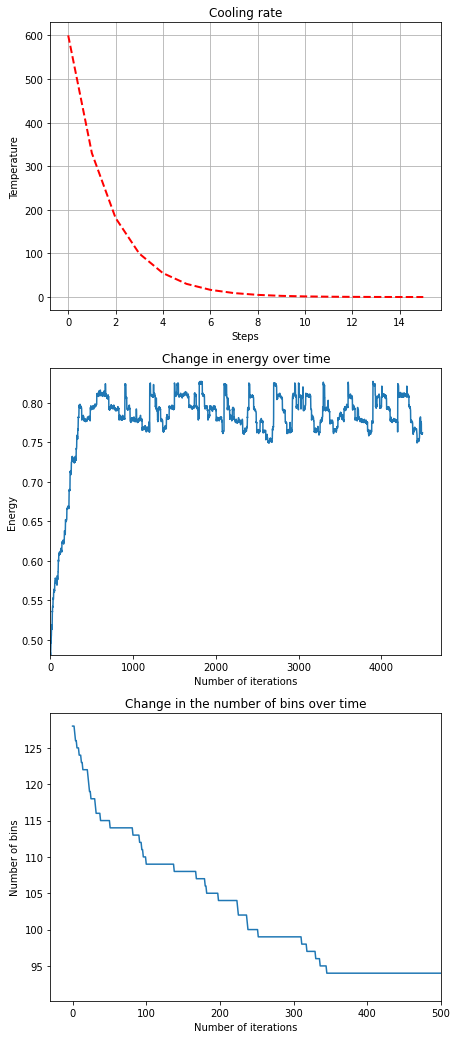

In [41]:
max_temp = max(df_v['Temperature'])
min_temp = min(df_v['Temperature'])
temp_list = [max_temp]

while max_temp > min_temp:
    max_temp *= 0.55
    temp_list.append(max_temp)

fig, axes = plt.subplots(3, 1, figsize =(7,18), dpi=72)
axes[0].plot([step for step in range(len(temp_list))],temp_list, color='r', ls='--' , lw=2)
axes[0].set_title('Cooling rate')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Temperature')
axes[0].grid(True)

axes[1].plot([step for step in range(len(df_v))],df_v['Energy'])
axes[1].set_title('Change in energy over time')
axes[1].set_xlabel('Number of iterations')
axes[1].set_ylabel('Energy')
axes[1].set_xlim(0)
axes[1].set_ylim(min(df_v['Energy']))

axes[2].plot([step for step in range(len(df_v))],df_v['Number of bins'])
axes[2].set_title('Change in the number of bins over time')
axes[2].set_xlabel('Number of iterations')
axes[2].set_ylabel('Number of bins')
axes[2].set_xlim(-30, 500)
plt.show()

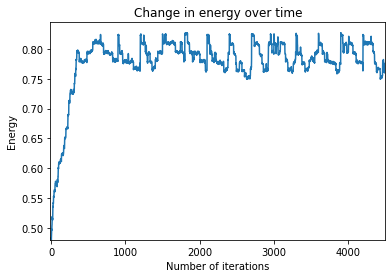

In [52]:
plt.plot([step for step in range(len(df_v))],df_v['Energy'])
plt.title('Change in energy over time')
plt.xlabel('Number of iterations')
plt.ylabel('Energy')
plt.xlim(-10,4500)
plt.ylim(min(df_v['Energy']))
plt.savefig('SA Fitness.jpeg')
plt.show()

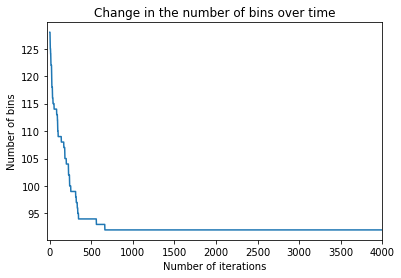

In [53]:
plt.plot([step for step in range(len(df_v))],df_v['Number of bins'])
plt.title('Change in the number of bins over time')
plt.xlabel('Number of iterations')
plt.ylabel('Number of bins')
plt.xlim(-30,4000)
plt.savefig('SA bin number.jpeg')
plt.show()